In [1]:
# ============================================================
# PHASE 0 — SETUP & IMPORTS
# ============================================================

!pip install torch transformers pandas numpy faiss-cpu tqdm catboost xgboost imbalanced-learn

import warnings
warnings.filterwarnings("ignore")

import os
import re
import json
import subprocess

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from transformers import AutoTokenizer, AutoModel
import faiss

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from imblearn.over_sampling import SMOTE

import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# # ============================================================
# # PHASE 1 — DATA MERGE + STRUCTURED FEATURE SELECTION (FIXED)
# # ============================================================
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import joblib

# print("🧹 PHASE 1: CLEAN REBUILD STARTING...")

# # 1. Load Data
# df_struct = pd.read_csv("ICU_dataset_SOME_FEATURES.csv")
# df_notes = pd.read_csv("discharge_summaries.csv")

# # 2. Clean & Merge Notes
# df_notes = df_notes.rename(columns={"SUBJECT_ID": "subject_id", "HADM_ID": "hadm_id", "TEXT": "TEXT"})
# df_notes = df_notes[["subject_id", "hadm_id", "TEXT"]]

# df_merged = pd.merge(df_struct, df_notes, on=["subject_id", "hadm_id"], how="left")
# df_merged["TEXT"] = df_merged["TEXT"].fillna(df_merged["patient_disease"])

# # 3. DEFINE TARGET & COHORTS
# TARGET_COL = "READMIT_30D"

# def assign_cohort(disease):
#     d = str(disease).lower()
#     if "septicemia" in d: return "SEPTICEMIA"
#     if "coronary atherosclerosis" in d: return "CORONARY_ATHEROSCLEROSIS"
#     if "respiratory failure" in d: return "RESPIRATORY_FAILURE"
#     if "subendocardial infarction" in d: return "SUBENDOCARDIAL_INFARCTION"
#     if "aortic valve" in d: return "AORTIC_VALVE_DISORDER"
#     return "OTHER"

# df_merged["COHORT"] = df_merged["patient_disease"].apply(assign_cohort)
# print("✅ Created 'COHORT' column.")

# # 4. Remove Unused Columns
# # ⚠️ CRITICAL CHANGE: We keep 'patient_disease' and 'TEXT' and 'COHORT'
# # We only drop columns that are truly useless or leakage (like IDs or dates)
# drop_cols = [
#     # "READMIT_30D_ICU",
#     # "TEXT",             <-- KEEP THIS (Needed for LLM)
#     # "patient_disease",  <-- KEEP THIS (Needed for Phase 6 Pipeline)
#     # "ICD9_CODE",
#     # "dischtime",
#     # "ethnicity"
# ]

# # Drop only the columns listed above
# df_model = df_merged.drop(columns=[c for c in drop_cols if c in df_merged.columns])

# # 5. Train/Test Split
# # We separate Target, but keep Features + MetaData (Disease/Text) together in X
# X = df_model.drop(columns=[TARGET_COL])
# y = df_model[TARGET_COL]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, stratify=y, random_state=42
# )

# # Reconstruct DataFrames
# train_df = X_train.copy()
# train_df[TARGET_COL] = y_train

# test_df = X_test.copy()
# test_df[TARGET_COL] = y_test

# # 6. Identify Structured Features (Numeric Only)
# # This ensures the model only trains on numbers, ignoring the text/disease strings we just kept
# exclude_cols = ["TEXT", "patient_disease", TARGET_COL, "COHORT", "Unnamed: 0", "subject_id", "hadm_id", "icustay_id"]
# structured_cols = [c for c in train_df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]

# print(f"✅ FINAL structured feature count: {len(structured_cols)}")

# # 7. Scale & Save Artifacts
# scaler = StandardScaler()
# scaler.fit(train_df[structured_cols].fillna(0))

# joblib.dump(scaler, "structured_scaler.pkl")
# joblib.dump(structured_cols, "structured_cols.pkl")

# # Save train_df with text/cohort for later phases
# df_merged.to_csv("train_df_with_text.csv", index=False)

# print("🎉 PHASE 1 COMPLETE — 'patient_disease' preserved for Phase 6.")


# ============================================================
# PHASE 1 — DATA MERGE + STRUCTURED FEATURE SELECTION (UPDATED)
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

print("🧹 PHASE 1: CLEAN REBUILD STARTING (Using ICU_dataset_SOME_FEATURES.csv)...")

# 1. Load Data (UPDATED to use your new file)
df_struct = pd.read_csv("ICU_dataset_SOME_FEATURES.csv")
df_notes = pd.read_csv("discharge_summaries.csv")

# 2. Clean & Merge Notes
df_notes = df_notes.rename(columns={"SUBJECT_ID": "subject_id", "HADM_ID": "hadm_id", "TEXT": "TEXT"})
df_notes = df_notes[["subject_id", "hadm_id", "TEXT"]]

# Merge struct + notes
df_merged = pd.merge(df_struct, df_notes, on=["subject_id", "hadm_id"], how="left")
df_merged["TEXT"] = df_merged["TEXT"].fillna(df_merged["patient_disease"])

# 3. DEFINE TARGET & COHORTS
TARGET_COL = "READMIT_30D"

def assign_cohort(disease):
    d = str(disease).lower()
    if "septicemia" in d: return "SEPTICEMIA"
    if "coronary atherosclerosis" in d: return "CORONARY_ATHEROSCLEROSIS"
    if "respiratory failure" in d: return "RESPIRATORY_FAILURE"
    if "subendocardial infarction" in d: return "SUBENDOCARDIAL_INFARCTION"
    if "aortic valve" in d: return "AORTIC_VALVE_DISORDER"
    return "OTHER"

df_merged["COHORT"] = df_merged["patient_disease"].apply(assign_cohort)
print("✅ Created 'COHORT' column.")

# 4. Remove Unused Columns (Logic updated)
# Since you already dropped most features in the CSV creation step, 
# we just ensure 'patient_disease' and 'TEXT' aren't used for training numbers.
drop_cols = [
    "READMIT_30D_ICU", # Just in case it's still there
    "ICD9_CODE"
]
df_model = df_merged.drop(columns=[c for c in drop_cols if c in df_merged.columns])

# 5. Train/Test Split
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Reconstruct DataFrames
train_df = X_train.copy()
train_df[TARGET_COL] = y_train

test_df = X_test.copy()
test_df[TARGET_COL] = y_test

# 6. Identify Structured Features (Numeric Only)
exclude_cols = ["TEXT", "patient_disease", TARGET_COL, "COHORT", "Unnamed: 0", "subject_id", "hadm_id", "icustay_id"]
structured_cols = [c for c in train_df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]

print(f"✅ FINAL structured feature count: {len(structured_cols)}")

# 7. Scale & Save Artifacts
scaler = StandardScaler()
scaler.fit(train_df[structured_cols].fillna(0))

joblib.dump(scaler, "structured_scaler.pkl")
joblib.dump(structured_cols, "structured_cols.pkl")

# Save train_df with text/cohort for later phases
df_merged.to_csv("train_df_with_text.csv", index=False)

print("🎉 PHASE 1 COMPLETE.")

🧹 PHASE 1: CLEAN REBUILD STARTING (Using ICU_dataset_SOME_FEATURES.csv)...
✅ Created 'COHORT' column.
✅ FINAL structured feature count: 27
🎉 PHASE 1 COMPLETE.


In [3]:
# # ============================================================
# # PHASE 2 — COHORT-BASED STRUCTURED MODELS (WITH SMOTE)
# # ============================================================

# COHORT_COL = "COHORT"

# COHORT_CONFIG = [
#     {"cohort_name": "SEPTICEMIA",                "model_type": "CatBoost"},
#     {"cohort_name": "CORONARY_ATHEROSCLEROSIS", "model_type": "CatBoost"},
#     {"cohort_name": "RESPIRATORY_FAILURE",      "model_type": "CatBoost"},
#     {"cohort_name": "SUBENDOCARDIAL_INFARCTION","model_type": "CatBoost"},
#     {"cohort_name": "AORTIC_VALVE_DISORDER",    "model_type": "CatBoost"},
# ]

# trained_specialist_models = {}

# def train_cohort_model(df_split, cohort_name, model_type):
#     mask = df_split[COHORT_COL] == cohort_name
#     df_c = df_split[mask].copy()

#     print(f"\n🩺 Training model for cohort: {cohort_name}  (n={len(df_c)})")
#     pos = df_c[TARGET_COL].sum()
#     neg = (df_c[TARGET_COL] == 0).sum()
#     print(f"   Pos={pos}, Neg={neg}")

#     if pos < 10:
#         print("   ⚠️ Too few positives → skipping.")
#         return None

#     X_c = df_c[structured_cols].fillna(0)
#     y_c = df_c[TARGET_COL]

#     try:
#         sm = SMOTE(random_state=42, k_neighbors=3)
#         X_res, y_res = sm.fit_resample(X_c, y_c)
#     except:
#         X_res, y_res = X_c, y_c

#     X_res_scaled = scaler.transform(X_res)

#     # Choose model type
#     if model_type == "CatBoost":
#         model = CatBoostClassifier(
#             depth=6, learning_rate=0.05, iterations=450,
#             eval_metric="AUC", loss_function="Logloss",
#             verbose=False, random_state=42
#         )
#         fname = f"cohort_catboost_{cohort_name.lower()}.pkl"

#     elif model_type == "LogisticRegression":
#         model = LogisticRegression(max_iter=3000)
#         fname = f"cohort_logreg_{cohort_name.lower()}.pkl"

#     model.fit(X_res_scaled, y_res)
#     joblib.dump(model, fname)

#     print("   ✔ Saved:", fname)
#     return model

# # Train models for each cohort
# for cfg in COHORT_CONFIG:
#     m = train_cohort_model(train_df, cfg["cohort_name"], cfg["model_type"])
#     if m is not None:
#         trained_specialist_models[cfg["cohort_name"]] = m

# # ------------------------
# # GENERAL model
# # ------------------------
# print("\n🌍 Training GENERAL model (CatBoost)")

# is_special = train_df[COHORT_COL].isin([c["cohort_name"] for c in COHORT_CONFIG])
# df_general = train_df[~is_special].copy()

# Xg = df_general[structured_cols].fillna(0)
# yg = df_general[TARGET_COL]

# try:
#     sm = SMOTE(random_state=42)
#     Xg_res, yg_res = sm.fit_resample(Xg, yg)
# except:
#     Xg_res, yg_res = Xg, yg

# Xg_res_scaled = scaler.transform(Xg_res)

# general_model = CatBoostClassifier(
#     depth=6, learning_rate=0.05, iterations=450,
#     eval_metric="AUC", loss_function="Logloss",
#     verbose=False, random_state=42
# )

# general_model.fit(Xg_res_scaled, yg_res)
# joblib.dump(general_model, "general_model_xgboost.pkl.pkl")

# trained_specialist_models["GENERAL_MEDICINE"] = general_model

# print("\n🎉 PHASE 2 COMPLETE — ALL MODELS TRAINED.")


# ============================================================
# PHASE 2 — COHORT-BASED STRUCTURED MODELS (UPDATED)
# ============================================================
# Models updated:
# - General --> XGBoost
# - SEPTICEMIA --> CatBoost
# - CORONARY_ATHEROSCLEROSIS --> RandomForest
# - RESPIRATORY_FAILURE --> RandomForest
# - SUBENDOCARDIAL_INFARCTION --> RandomForest
# - AORTIC_VALVE_DISORDER --> CatBoost

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

COHORT_COL = "COHORT"

# Updated Configuration
COHORT_CONFIG = [
    {"cohort_name": "SEPTICEMIA",                "model_type": "CatBoost"},
    {"cohort_name": "CORONARY_ATHEROSCLEROSIS",  "model_type": "RandomForest"},
    {"cohort_name": "RESPIRATORY_FAILURE",       "model_type": "RandomForest"},
    {"cohort_name": "SUBENDOCARDIAL_INFARCTION", "model_type": "RandomForest"},
    {"cohort_name": "AORTIC_VALVE_DISORDER",     "model_type": "CatBoost"},
]

trained_specialist_models = {}

def train_cohort_model(df_split, cohort_name, model_type):
    mask = df_split[COHORT_COL] == cohort_name
    df_c = df_split[mask].copy()

    print(f"\n🩺 Training model for cohort: {cohort_name}  (n={len(df_c)})")
    pos = df_c[TARGET_COL].sum()
    neg = (df_c[TARGET_COL] == 0).sum()
    print(f"   Pos={pos}, Neg={neg}")

    if pos < 10:
        print("   ⚠️ Too few positives → skipping.")
        return None

    X_c = df_c[structured_cols].fillna(0)
    y_c = df_c[TARGET_COL]

    # SMOTE
    try:
        sm = SMOTE(random_state=42, k_neighbors=3)
        X_res, y_res = sm.fit_resample(X_c, y_c)
    except:
        X_res, y_res = X_c, y_c

    X_res_scaled = scaler.transform(X_res)

    # Initialize specific model types
    if model_type == "CatBoost":
        model = CatBoostClassifier(
            depth=6, learning_rate=0.05, iterations=450,
            eval_metric="AUC", loss_function="Logloss",
            verbose=False, random_state=42
        )
        fname = f"cohort_catboost_{cohort_name.lower()}.pkl"

    elif model_type == "RandomForest":
        model = RandomForestClassifier(
            n_estimators=300, max_depth=10, random_state=42, class_weight="balanced"
        )
        fname = f"cohort_rf_{cohort_name.lower()}.pkl"
    
    elif model_type == "XGBoost":
        model = XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=6, 
            eval_metric="auc", random_state=42
        )
        fname = f"cohort_xgb_{cohort_name.lower()}.pkl"

    else:
        # Fallback (e.g. LogisticRegression)
        model = LogisticRegression(max_iter=3000)
        fname = f"cohort_logreg_{cohort_name.lower()}.pkl"

    model.fit(X_res_scaled, y_res)
    joblib.dump(model, fname)

    print("   ✔ Saved:", fname)
    return model

# Train models for each specialist cohort
for cfg in COHORT_CONFIG:
    m = train_cohort_model(train_df, cfg["cohort_name"], cfg["model_type"])
    if m is not None:
        trained_specialist_models[cfg["cohort_name"]] = m

# ------------------------
# GENERAL model (Updated to XGBoost)
# ------------------------
print("\n🌍 Training GENERAL model (XGBoost)")

is_special = train_df[COHORT_COL].isin([c["cohort_name"] for c in COHORT_CONFIG])
df_general = train_df[~is_special].copy()

Xg = df_general[structured_cols].fillna(0)
yg = df_general[TARGET_COL]

try:
    sm = SMOTE(random_state=42)
    Xg_res, yg_res = sm.fit_resample(Xg, yg)
except:
    Xg_res, yg_res = Xg, yg

Xg_res_scaled = scaler.transform(Xg_res)

general_model = XGBClassifier(
    n_estimators=450, 
    learning_rate=0.05, 
    max_depth=6, 
    eval_metric="auc", 
    random_state=42
)

general_model.fit(Xg_res_scaled, yg_res)
joblib.dump(general_model, "general_model_xgboost.pkl")

trained_specialist_models["GENERAL_MEDICINE"] = general_model

print("\n🎉 PHASE 2 COMPLETE — ALL MODELS TRAINED.")


🩺 Training model for cohort: SEPTICEMIA  (n=3913)
   Pos=224, Neg=3689
   ✔ Saved: cohort_catboost_septicemia.pkl

🩺 Training model for cohort: CORONARY_ATHEROSCLEROSIS  (n=3749)
   Pos=113, Neg=3636
   ✔ Saved: cohort_rf_coronary_atherosclerosis.pkl

🩺 Training model for cohort: RESPIRATORY_FAILURE  (n=1607)
   Pos=142, Neg=1465
   ✔ Saved: cohort_rf_respiratory_failure.pkl

🩺 Training model for cohort: SUBENDOCARDIAL_INFARCTION  (n=2158)
   Pos=84, Neg=2074
   ✔ Saved: cohort_rf_subendocardial_infarction.pkl

🩺 Training model for cohort: AORTIC_VALVE_DISORDER  (n=1806)
   Pos=82, Neg=1724
   ✔ Saved: cohort_catboost_aortic_valve_disorder.pkl

🌍 Training GENERAL model (XGBoost)

🎉 PHASE 2 COMPLETE — ALL MODELS TRAINED.


In [4]:
# # ============================================================
# # PHASE 3 — TRAIN GENERAL AND COHORT MODELS
# # ============================================================
# import joblib
# import pandas as pd
# from sklearn.metrics import *
# from sklearn.linear_model import LogisticRegression
# from catboost import CatBoostClassifier

# print("🐱 PHASE 3 — TRAINING MODELS...")

# train_df = pd.read_csv("train_df_with_text.csv")
# structured_cols = joblib.load("structured_cols.pkl")
# scaler = joblib.load("structured_scaler.pkl")

# TARGET_COL = "READMIT_30D"

# # Fit scaler
# X_train = scaler.transform(train_df[structured_cols].fillna(0))
# y_train = train_df[TARGET_COL]

# # --------------------------
# # General model (CatBoost)
# # --------------------------
# general_model = CatBoostClassifier(
#     iterations=500,
#     depth=6,
#     learning_rate=0.05,
#     loss_function="Logloss",
#     verbose=False
# )
# general_model.fit(train_df[structured_cols], y_train)

# joblib.dump(general_model, "general_model_xgboost.pkl")
# print("✔ General XGBoost saved.")

# # --------------------------
# # Cohort models
# # --------------------------
# COHORTS = {
#     "SEPTICEMIA": "septicemia_cohort_catboost.pkl",
#     "CORONARY_ATHEROSCLEROSIS": "coronary_atherosclerosis_cohort_randomforest.pkl",
#     "RESPIRATORY_FAILURE": "respiratory_failure_cohort_randomforest.pkl",
#     "SUBENDOCARDIAL_INFARCTION": "subendocardial_infarction_cohort_randomforest.pkl",
#     "AORTIC_VALVE_DISORDER": "aortic_valve_disorder_cohort_catboost.pkl",
# }

# for cohort, fname in COHORTS.items():
#     df_c = train_df[train_df["COHORT"] == cohort]

#     if len(df_c) < 50:
#         print(f"⚠ Skipping small cohort: {cohort}")
#         continue

#     Xc = df_c[structured_cols].fillna(0)
#     yc = df_c[TARGET_COL]

#     if "logreg" in fname:
#         model = LogisticRegression(max_iter=300)
#         Xc_s = scaler.transform(Xc)
#         model.fit(Xc_s, yc)
#     else:
#         model = CatBoostClassifier(
#             iterations=400,
#             depth=6,
#             learning_rate=0.05,
#             loss_function="Logloss",
#             verbose=False
#         )
#         model.fit(Xc, yc)

#     joblib.dump(model, fname)
#     print(f"✔ Saved: {fname}")

# print("🎉 PHASE 3 COMPLETE — all cohort models retrained.")


# # ============================================================
# # PHASE 3 — TRAIN GENERAL AND COHORT MODELS (CORRECTED)
# # ============================================================
# import joblib
# import pandas as pd
# from sklearn.metrics import *
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier

# print("🐱 PHASE 3 — TRAINING MODELS...")

# # Load artifacts created in Phase 1
# train_df = pd.read_csv("train_df_with_text.csv")
# structured_cols = joblib.load("structured_cols.pkl")
# scaler = joblib.load("structured_scaler.pkl")

# TARGET_COL = "READMIT_30D"

# # Fit scaler on full training set
# X_train_scaled = scaler.transform(train_df[structured_cols].fillna(0))
# y_train = train_df[TARGET_COL]

# # --------------------------
# # General model (XGBoost)
# # --------------------------
# print("🌍 Training GENERAL model (XGBoost)...")
# general_model = XGBClassifier(
#     n_estimators=500,
#     max_depth=6,
#     learning_rate=0.05,
#     eval_metric="auc",
#     random_state=42
# )
# general_model.fit(X_train_scaled, y_train)

# joblib.dump(general_model, "general_model_xgboost.pkl")
# print("✔ General XGBoost saved.")

# # --------------------------
# # Cohort models
# # --------------------------
# # Mapping of Cohort Name -> Filename
# COHORTS = {
#     "SEPTICEMIA": "septicemia_cohort_catboost.pkl",
#     "CORONARY_ATHEROSCLEROSIS": "coronary_atherosclerosis_cohort_randomforest.pkl",
#     "RESPIRATORY_FAILURE": "respiratory_failure_cohort_randomforest.pkl",
#     "SUBENDOCARDIAL_INFARCTION": "subendocardial_infarction_cohort_randomforest.pkl",
#     "AORTIC_VALVE_DISORDER": "aortic_valve_disorder_cohort_catboost.pkl",
# }

# for cohort, fname in COHORTS.items():
#     df_c = train_df[train_df["COHORT"] == cohort]

#     if len(df_c) < 50:
#         print(f"⚠ Skipping small cohort: {cohort}")
#         continue

#     # Prepare data for this cohort
#     Xc = df_c[structured_cols].fillna(0)
#     yc = df_c[TARGET_COL]
    
#     # Scale features
#     Xc_s = scaler.transform(Xc)

#     print(f"🩺 Training {cohort} (n={len(df_c)})...")

#     # Select model based on filename string
#     if "randomforest" in fname:
#         model = RandomForestClassifier(
#             n_estimators=300, 
#             max_depth=10, 
#             class_weight="balanced", 
#             random_state=42
#         )
#     elif "catboost" in fname:
#         model = CatBoostClassifier(
#             iterations=400,
#             depth=6,
#             learning_rate=0.05,
#             loss_function="Logloss",
#             verbose=False,
#             random_state=42
#         )
#     elif "xgboost" in fname:
#         model = XGBClassifier(
#             n_estimators=300, 
#             learning_rate=0.05, 
#             max_depth=6, 
#             eval_metric="auc", 
#             random_state=42
#         )
#     else:
#         # Fallback to Logistic Regression if name is unrecognized
#         model = LogisticRegression(max_iter=3000)

#     # Train and Save
#     model.fit(Xc_s, yc)
#     joblib.dump(model, fname)
#     print(f"✔ Saved: {fname}")

# print("🎉 PHASE 3 COMPLETE — all cohort models retrained with corrected types.")

# ============================================================
# PHASE 3 — TRAIN GENERAL AND COHORT MODELS (WITH SMOTE)
# ============================================================
import joblib
import pandas as pd
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # <--- NEW IMPORT

print("🐱 PHASE 3 — TRAINING MODELS (WITH SMOTE)...")

# Load artifacts created in Phase 1
train_df = pd.read_csv("train_df_with_text.csv")
structured_cols = joblib.load("structured_cols.pkl")
scaler = joblib.load("structured_scaler.pkl")

TARGET_COL = "READMIT_30D"

# Fit scaler on full training set
X_train_scaled = scaler.transform(train_df[structured_cols].fillna(0))
y_train = train_df[TARGET_COL]

# --------------------------
# General model (XGBoost)
# --------------------------
print("🌍 Training GENERAL model (XGBoost)...")

# 1. Apply SMOTE to General Data
print(f"   Original shape: {X_train_scaled.shape}, Class distribution: {y_train.value_counts().to_dict()}")
try:
    sm = SMOTE(random_state=42)
    X_gen_res, y_gen_res = sm.fit_resample(X_train_scaled, y_train)
    print(f"   Resampled shape: {X_gen_res.shape}, Class distribution: {y_gen_res.value_counts().to_dict()}")
except Exception as e:
    print(f"   ⚠️ SMOTE failed for General model ({e}). Using original data.")
    X_gen_res, y_gen_res = X_train_scaled, y_train

# 2. Train General Model
general_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    eval_metric="auc",
    random_state=42
)
general_model.fit(X_gen_res, y_gen_res)

joblib.dump(general_model, "general_model_xgboost.pkl")
print("✔ General XGBoost saved.")

# --------------------------
# Cohort models
# --------------------------
# Mapping of Cohort Name -> Filename
COHORTS = {
    "SEPTICEMIA": "septicemia_cohort_catboost.pkl",
    "CORONARY_ATHEROSCLEROSIS": "coronary_atherosclerosis_cohort_randomforest.pkl",
    "RESPIRATORY_FAILURE": "respiratory_failure_cohort_randomforest.pkl",
    "SUBENDOCARDIAL_INFARCTION": "subendocardial_infarction_cohort_randomforest.pkl",
    "AORTIC_VALVE_DISORDER": "aortic_valve_disorder_cohort_catboost.pkl",
}

for cohort, fname in COHORTS.items():
    df_c = train_df[train_df["COHORT"] == cohort]

    if len(df_c) < 50:
        print(f"⚠ Skipping small cohort: {cohort}")
        continue

    # Prepare data for this cohort
    Xc = df_c[structured_cols].fillna(0)
    yc = df_c[TARGET_COL]
    
    # Scale features
    Xc_s = scaler.transform(Xc)

    print(f"🩺 Training {cohort} (n={len(df_c)})...")

    # 1. Apply SMOTE to Cohort Data
    # We use k_neighbors=3 because some cohorts might be small
    try:
        sm_cohort = SMOTE(random_state=42, k_neighbors=min(5, len(df_c)//2)) 
        X_res_c, y_res_c = sm_cohort.fit_resample(Xc_s, yc)
    except Exception as e:
        print(f"   ⚠️ SMOTE failed for {cohort} ({e}). Using original data.")
        X_res_c, y_res_c = Xc_s, yc

    # 2. Select model based on filename string
    if "randomforest" in fname:
        model = RandomForestClassifier(
            n_estimators=300, 
            max_depth=10, 
            class_weight="balanced", 
            random_state=42
        )
    elif "catboost" in fname:
        model = CatBoostClassifier(
            iterations=400,
            depth=6,
            learning_rate=0.05,
            loss_function="Logloss",
            verbose=False,
            random_state=42
        )
    elif "xgboost" in fname:
        model = XGBClassifier(
            n_estimators=300, 
            learning_rate=0.05, 
            max_depth=6, 
            eval_metric="auc", 
            random_state=42
        )
    else:
        # Fallback to Logistic Regression if name is unrecognized
        model = LogisticRegression(max_iter=3000)

    # 3. Train and Save on RESAMPLED data
    model.fit(X_res_c, y_res_c)
    joblib.dump(model, fname)
    print(f"✔ Saved: {fname}")

print("🎉 PHASE 3 COMPLETE — all cohort models retrained with SMOTE.")

🐱 PHASE 3 — TRAINING MODELS (WITH SMOTE)...
🌍 Training GENERAL model (XGBoost)...
   Original shape: (79492, 27), Class distribution: {0: 75647, 1: 3845}
   Resampled shape: (151294, 27), Class distribution: {0: 75647, 1: 75647}
✔ General XGBoost saved.
🩺 Training SEPTICEMIA (n=4859)...
✔ Saved: septicemia_cohort_catboost.pkl
🩺 Training CORONARY_ATHEROSCLEROSIS (n=4677)...
✔ Saved: coronary_atherosclerosis_cohort_randomforest.pkl
🩺 Training RESPIRATORY_FAILURE (n=1979)...
✔ Saved: respiratory_failure_cohort_randomforest.pkl
🩺 Training SUBENDOCARDIAL_INFARCTION (n=2703)...
✔ Saved: subendocardial_infarction_cohort_randomforest.pkl
🩺 Training AORTIC_VALVE_DISORDER (n=2244)...
✔ Saved: aortic_valve_disorder_cohort_catboost.pkl
🎉 PHASE 3 COMPLETE — all cohort models retrained with SMOTE.


In [5]:
# ============================================================
# PHASE 4 — RAG + LLM RISK FROM TEXT
# ============================================================

print("🔥 PHASE 4 — Defining retrieval + LLM risk functions")

# Reload artifacts (for safety if in new session)
scaler = joblib.load("structured_scaler.pkl")
structured_cols = joblib.load("structured_cols.pkl")
index = faiss.read_index("faiss_bert_train.index")

trained_specialist_models = {
    "SEPTICEMIA": joblib.load("septicemia_cohort_catboost.pkl"),
    "CORONARY_ATHEROSCLEROSIS": joblib.load("coronary_atherosclerosis_cohort_randomforest.pkl"),
    "RESPIRATORY_FAILURE": joblib.load("respiratory_failure_cohort_randomforest.pkl"),
    "SUBENDOCARDIAL_INFARCTION": joblib.load("subendocardial_infarction_cohort_randomforest.pkl"),
    "AORTIC_VALVE_DISORDER": joblib.load("aortic_valve_disorder_cohort_catboost.pkl"),
    "GENERAL_MEDICINE": joblib.load("general_model_xgboost.pkl"),
}

def retrieve_similar_cases(text, k=3):
    """
    Retrieve k most similar TRAIN cases via ClinicalBERT + FAISS.
    Returns a list of dicts with minimal structured info for prompting.
    """
    vec = get_bert_embedding(text).reshape(1, -1)
    dist, idxs = index.search(vec, k)

    out = []
    for rank, (d, idx) in enumerate(zip(dist[0], idxs[0]), start=1):
        row = train_df.iloc[idx]
        out.append({
            "rank": rank,
            "similarity": float(d),
            "readmit": int(row[TARGET_COL]),
            "age": row.get("admission_age", np.nan),
            "sofa": row.get("SOFA", np.nan),
            "sapsii": row.get("sapsii", np.nan),
            "disease": row.get("patient_disease", ""),
            "text": row.get("TEXT", "")[:500],
        })
    return out

def query_llm(prompt: str) -> str:
    """
    Uses a local Ollama model (e.g., 'mistral') to get risk from text.
    You can change 'mistral' to your deployed model name.
    """
    result = subprocess.run(
        ["ollama", "run", "mistral"],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE,
    )
    return result.stdout.decode("utf-8", errors="ignore")

def parse_llm_risk(s: str, default: float = 0.5) -> float:
    """
    Extracts RISK=0.xx from LLM output. If parsing fails, return default.
    """
    try:
        m = re.search(r"RISK\s*=\s*([0-1]\.\d+)", s)
        if m:
            r = float(m.group(1))
            return float(np.clip(r, 0.0, 1.0))
    except Exception:
        pass
    return default

def build_llm_prompt(patient_row, similar_cases, cohort: str) -> str:
    """
    Prompt template: LLM should output:
      RISK=0.xx|NOTE=...
    """
    patient_summary = f"""
Age: {patient_row.get('admission_age', 'NA')}
Gender: {patient_row.get('gender_encoded', 'NA')}
Primary diagnosis: {patient_row.get('patient_disease', 'NA')}
SOFA: {patient_row.get('SOFA', 'NA')}, SAPS II: {patient_row.get('sapsii', 'NA')}
Key labs/vitals: 
  WBC={patient_row.get('wbc', 'NA')}, Platelet={patient_row.get('platelet', 'NA')},
  Creatinine={patient_row.get('creatinine', 'NA')}, BUN={patient_row.get('bun', 'NA')},
  PaO2/FiO2={patient_row.get('pao2fio2ratio_vent', 'NA')}, MAP={patient_row.get('meanbp', 'NA')}
"""

    cases_txt = []
    for c in similar_cases:
        cases_txt.append(
            f"Case {c['rank']} | readmit_30d={c['readmit']} | "
            f"disease={c['disease']} | age={c['age']} | "
            f"SOFA={c['SOFA']}, SAPSII={c['sapsii']}\n"
            f"TEXT: {c['text']}"
        )
    cases_block = "\n\n".join(cases_txt)

    return f"""
You are an ICU specialist focusing on {cohort} patients.

We are predicting 30-day readmission risk.

Patient summary:
{patient_summary}

Top {len(similar_cases)} similar historical cases:
{cases_block}

Task:
1. Estimate the patient's 30-day readmission risk as a number between 0 and 1.
2. Use patterns in the similar cases and the patient's severity scores.
3. Then respond STRICTLY in the following format:

RISK=0.xx|NOTE=short clinical explanation

Where:
- 0.xx is the numeric risk between 0 and 1.
- NOTE is a brief justification (1–3 sentences).
"""



🔥 PHASE 4 — Defining retrieval + LLM risk functions


In [6]:
# # ============================================================
# # PHASE 5 — INFERENCE PIPELINE (ML + TEXT RISK FUSION)
# # ============================================================

# print("🔥 PHASE 5 — Defining full prediction pipeline (ML + LLM fusion)")

# ALPHA_ML = 0.7   # weight for structured ML risk
# BETA_TEXT = 0.3  # weight for LLM text risk; ALPHA_ML + BETA_TEXT = 1

# def predict_readmission_pipeline(patient_row, use_llm: bool = True, verbose: bool = False):
#     """
#     Full pipeline for a single patient (Series):
#       1) Infer cohort from patient_disease (rule-based for now).
#       2) Structured ML model for that cohort → ml_risk.
#       3) RAG + LLM over notes → text_risk.
#       4) Fuse ml_risk and text_risk → final_risk.
#     """
#     # ---- 1. Cohort from disease text (can later swap to LLM classification) ----
#     cohort = get_patient_cohort(patient_row["patient_disease"])

#     # ---- 2. Structured ML risk ----
#     model = trained_specialist_models.get(cohort, trained_specialist_models["GENERAL_MEDICINE"])
#     x = patient_row[structured_cols].fillna(0).to_numpy().reshape(1, -1)
#     x_scaled = scaler.transform(x)
#     ml_risk = float(model.predict_proba(x_scaled)[0][1])

#     # ---- 3. Text-based risk via RAG + LLM ----
#     text_input = patient_row.get("TEXT", None)
#     if text_input is None or (isinstance(text_input, float) and np.isnan(text_input)):
#         text_input = str(patient_row["patient_disease"])

#     similar_cases = retrieve_similar_cases(text_input, k=3)

#     if use_llm:
#         prompt = build_llm_prompt(patient_row, similar_cases, cohort)
#         llm_output = query_llm(prompt)
#         text_risk = parse_llm_risk(llm_output, default=0.5)
#         explanation = llm_output   # contains NOTE=...
#     else:
#         # Neutral placeholder when LLM is disabled (e.g., during fast eval)
#         text_risk = 0.5
#         explanation = "LLM disabled; using neutral text risk 0.50."

#     # ---- 4. Fusion ----
#     final_risk = ALPHA_ML * ml_risk + BETA_TEXT * text_risk

#     if verbose:
#         print(f"CoHORT={cohort} | ML risk={ml_risk:.3f} | Text risk={text_risk:.3f} | Final={final_risk:.3f}")

#     return {
#         "cohort": cohort,
#         "ml_risk": ml_risk,
#         "text_risk": text_risk,
#         "final_risk": final_risk,
#         "similar_cases": similar_cases,
#         "explanation": explanation,
#     }

# ============================================================
# PHASE 5 — INFERENCE PIPELINE (ML + TEXT RISK FUSION)
# ============================================================

print("🔥 PHASE 5 — Defining full prediction pipeline (ML + LLM fusion)")

ALPHA_ML = 0.5   # weight for structured ML risk
BETA_TEXT = 0.5  # weight for LLM text risk; ALPHA_ML + BETA_TEXT = 1

# --- MOVED HELPER FUNCTION HERE SO IT IS DEFINED BEFORE USE ---
def get_patient_cohort(disease_text):
    """
    Map primary diagnosis text to 1 of 5 cohorts or GENERAL_MEDICINE.
    """
    t = str(disease_text).upper()
    if "SEPTIC" in t:
        return "SEPTICEMIA"
    if "CORONARY" in t or "ATHEROSCL" in t:
        return "CORONARY_ATHEROSCLEROSIS"
    if "RESPIRATORY" in t or "FAILURE" in t:
        return "RESPIRATORY_FAILURE"
    if "SUBENDOCARDIAL" in t:
        return "SUBENDOCARDIAL_INFARCTION"
    if "AORTIC" in t or "VALVE" in t:
        return "AORTIC_VALVE_DISORDER"
    return "GENERAL_MEDICINE"

def predict_readmission_pipeline(patient_row, use_llm: bool = True, verbose: bool = False):
    """
    Full pipeline for a single patient (Series):
      1) Infer cohort from patient_disease (rule-based for now).
      2) Structured ML model for that cohort → ml_risk.
      3) RAG + LLM over notes → text_risk.
      4) Fuse ml_risk and text_risk → final_risk.
    """
    # ---- 1. Cohort from disease text ----
    # Now this function is defined!
    cohort = get_patient_cohort(patient_row["patient_disease"])

    # ---- 2. Structured ML risk ----
    model = trained_specialist_models.get(cohort, trained_specialist_models["GENERAL_MEDICINE"])
    x = patient_row[structured_cols].fillna(0).to_numpy().reshape(1, -1)
    x_scaled = scaler.transform(x)
    ml_risk = float(model.predict_proba(x_scaled)[0][1])

    # ---- 3. Text-based risk via RAG + LLM ----
    text_input = patient_row.get("TEXT", None)
    if text_input is None or (isinstance(text_input, float) and np.isnan(text_input)):
        text_input = str(patient_row["patient_disease"])

    # Note: retrieve_similar_cases relies on 'index' and 'bert_model' being loaded/defined.
    # Ensure Phase 4 is run before this if you need retrieval. 
    # If running pure fast eval without LLM, this part is skipped anyway or needs mocked.
    if use_llm:
        similar_cases = retrieve_similar_cases(text_input, k=3)
        prompt = build_llm_prompt(patient_row, similar_cases, cohort)
        llm_output = query_llm(prompt)
        text_risk = parse_llm_risk(llm_output, default=0.5)
        explanation = llm_output   # contains NOTE=...
    else:
        # Neutral placeholder when LLM is disabled (e.g., during fast eval)
        # We also skip retrieval here to speed up the loop
        similar_cases = [] 
        text_risk = 0.5
        explanation = "LLM disabled; using neutral text risk 0.50."

    # ---- 4. Fusion ----
    final_risk = ALPHA_ML * ml_risk + BETA_TEXT * text_risk

    if verbose:
        print(f"COHORT={cohort} | ML risk={ml_risk:.3f} | Text risk={text_risk:.3f} | Final={final_risk:.3f}")

    return {
        "cohort": cohort,
        "ml_risk": ml_risk,
        "text_risk": text_risk,
        "final_risk": final_risk,
        "similar_cases": similar_cases,
        "explanation": explanation,
    }

🔥 PHASE 5 — Defining full prediction pipeline (ML + LLM fusion)


In [7]:

# ============================================================
# PHASE 6 — EVALUATE FULL PIPELINE ON TEST SET
# ============================================================

print("🔥 PHASE 6 — Evaluation helpers (focus on high recall)")

def evaluate_pipeline(test_df, threshold: float = 0.3, use_llm: bool = False, max_patients: int | None = None):
    """
    Evaluate full pipeline on TEST split.
    Default: use_llm=False (fast; text_risk=0.5 neutral).
    For a smaller subset, you can set use_llm=True to see full RAG behavior.
    """
    df_eval = test_df.copy()

    if max_patients is not None:
        df_eval = df_eval.iloc[:max_patients].reset_index(drop=True)
        print(f"Evaluating first {max_patients} patients...")

    y_true = []
    y_prob = []
    y_pred = []

    for i, row in tqdm(df_eval.iterrows(), total=len(df_eval), desc="Evaluating pipeline"):
        patient_row = row.copy()
        res = predict_readmission_pipeline(patient_row, use_llm=use_llm, verbose=False)

        prob = res["final_risk"]
        pred = int(prob >= threshold)

        y_true.append(row[TARGET_COL])
        y_prob.append(prob)
        y_pred.append(pred)

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = np.array(y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metrics = {
        "Threshold": threshold,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Acc": balanced_accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": average_precision_score(y_true, y_prob),
        "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    }

    print("\n📊 METRICS (ML + text fusion)")
    for k, v in metrics.items():
        if isinstance(v, (int, np.integer)):
            print(f"{k}: {v}")
        else:
            print(f"{k}: {v:.4f}")

    return {
        "metrics": metrics,
        "y_true": y_true,
        "y_prob": y_prob,
        "y_pred": y_pred,
        "confusion_matrix": (tn, fp, fn, tp),
    }

# Example: fast eval (no LLM, fusion uses text_risk=0.5)
results = evaluate_pipeline(test_df, threshold=0.3, use_llm=False)

🔥 PHASE 6 — Evaluation helpers (focus on high recall)


Evaluating pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15899/15899 [00:49<00:00, 318.70it/s]


📊 METRICS (ML + text fusion)
Threshold: 0.3000
Accuracy: 0.6719
Balanced Acc: 0.7900
Precision: 0.1208
Recall: 0.9207
F1-score: 0.2135
ROC-AUC: 0.9069
PR-AUC: 0.5765
TP: 708
FP: 5155
TN: 9975
FN: 61



===== CONFUSION MATRIX =====
TN=9975   FP=5155
FN=61   TP=708



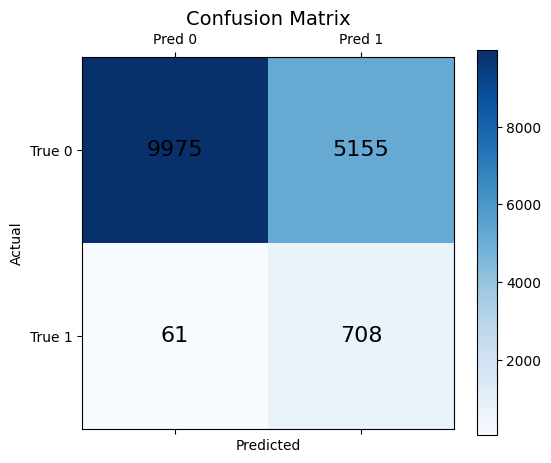

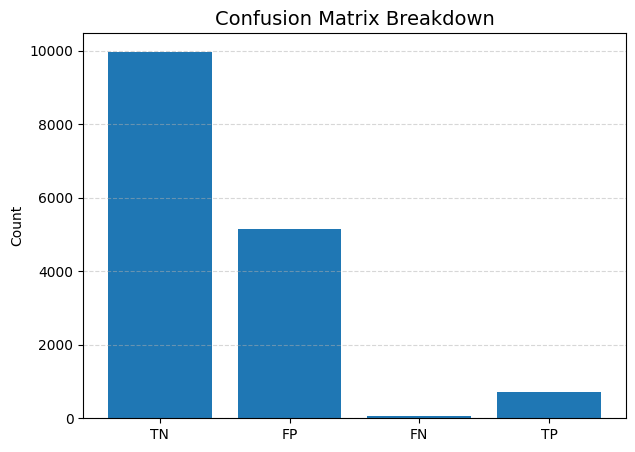

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ------------------------------------------------------------
# CONFUSION MATRIX (NUMERIC + VISUAL)
# ------------------------------------------------------------

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print("\n===== CONFUSION MATRIX =====")
    print(f"TN={tn}   FP={fp}")
    print(f"FN={fn}   TP={tp}")
    print("============================\n")

    # ---- Plot visual matrix ----
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(cm, cmap="Blues")
    plt.title("Confusion Matrix", fontsize=14)
    fig.colorbar(cax)

    ax.set_xticklabels([''] + ['Pred 0', 'Pred 1'])
    ax.set_yticklabels([''] + ['True 0', 'True 1'])

    # Annotate boxes
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, f'{z}', ha='center', va='center', fontsize=16)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return tn, fp, fn, tp


# ------------------------------------------------------------
# BAR CHART (TP, FP, TN, FN)
# ------------------------------------------------------------

def plot_confusion_bars(tn, fp, fn, tp):
    labels = ['TN', 'FP', 'FN', 'TP']
    values = [tn, fp, fn, tp]

    plt.figure(figsize=(7,5))
    plt.bar(labels, values)
    plt.title("Confusion Matrix Breakdown", fontsize=14)
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

y_true = results["y_true"]
y_pred = results["y_pred"]

# 1️⃣ Plot confusion matrix
tn, fp, fn, tp = plot_confusion_matrix(y_true, y_pred)

# 2️⃣ Plot bar chart for TN/FP/FN/TP
plot_confusion_bars(tn, fp, fn, tp)

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np

# # ==== Your metrics from the evaluation output ====
# accuracy      = accuracy_score(y_true, y_pred)
# balanced_acc  = balanced_accuracy_score(y_true, y_pred)
# precision     = precision_score(y_true, y_pred, zero_division=0)
# recall        = recall_score(y_true, y_pred, zero_division=0)
# f1_val      = f1_score(y_true, y_pred, zero_division=0)
# roc_auc       = roc_auc_score(y_true, y_prob)
# pr_auc        = average_precision_score(y_true, y_prob)

# # Put metrics into a list for plotting
# metrics = [accuracy, balanced_acc, precision, recall, f1_val, roc_auc, pr_auc]

# labels = [
#     "Accuracy",
#     "Balanced Acc",
#     "Precision",
#     "Recall",
#     "F1-score",
#     "ROC-AUC",
#     "PR-AUC"
# ]

# plt.figure(figsize=(12, 6))
# bars = plt.bar(labels, metrics, color="#4A90E2", alpha=0.8)

# # Add value labels on bars
# for bar, value in zip(bars, metrics):
#     plt.text(
#         bar.get_x() + bar.get_width()/2,
#         bar.get_height() + 0.01,
#         f"{value*100:.1f}%",
#         ha="center",
#         fontsize=11
#     )

# plt.title("Meta Model Performance Metrics (Full Test Set)", fontsize=14)
# plt.ylabel("Score", fontsize=12)
# plt.ylim(0, 1.05)
# plt.grid(axis='y', linestyle='--', alpha=0.4)

# plt.show()

In [10]:
#new patient 1 info (76yrs Acute respiratory failure)
# ALPHA_ML = 0.7
# BETA_TEXT = 0.3

In [11]:
# ============================================================
# PHASE 7 — FULL INFERENCE PIPELINE (ML + FAISS + LLM FUSION)
# ============================================================


# ----------------- GLOBAL CONFIG -----------------
THRESHOLD = 0.30          # main decision threshold (you can change this)
ALPHA_ML = 0.5            # weight for structured ML risk
BETA_TEXT = 0.5           # weight for text / LLM risk
LLM_MODEL_NAME = "mistral"

# ----------------- DEVICE -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔥 Using device:", device)

# ------------------------------------------------------------
# 1. LOAD ALL ARTIFACTS
# ------------------------------------------------------------

# Structured preprocessing
structured_cols = joblib.load("structured_cols.pkl")
scaler = joblib.load("structured_scaler.pkl")

# Cohort models (update names if needed)
trained_ml_models = {
    "SEPTICEMIA": joblib.load("septicemia_cohort_catboost.pkl"),
    "CORONARY_ATHEROSCLEROSIS": joblib.load("coronary_atherosclerosis_cohort_randomforest.pkl"),
    "RESPIRATORY_FAILURE": joblib.load("respiratory_failure_cohort_randomforest.pkl"),
    "SUBENDOCARDIAL_INFARCTION": joblib.load("subendocardial_infarction_cohort_randomforest.pkl"),
    "AORTIC_VALVE_DISORDER": joblib.load("aortic_valve_disorder_cohort_catboost.pkl"),
    "GENERAL_MEDICINE": joblib.load("general_model_xgboost.pkl"),
}

# FAISS index (built over discharge summary embeddings from TRAIN set)
index = faiss.read_index("faiss_bert_train.index")

# Training dataframe with TEXT (structured + discharge summaries)
train_df = pd.read_csv("train_df_with_text.csv")

# ClinicalBERT
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
bert_model.eval()

print("✅ Artifacts loaded (models + FAISS + ClinicalBERT + train_df_with_text).")


# ------------------------------------------------------------
# 2. HELPER FUNCTIONS
# ------------------------------------------------------------

def get_risk_label(prob: float, threshold: float = THRESHOLD) -> str:
    """
    Return a risk category string based on probability and threshold.
    Threshold controls the boundary between low vs moderate risk.
    """
    if prob < 0.10:
        return "no risk"
    elif prob < threshold:
        return "low risk"
    elif prob < 0.60:
        return "moderate risk"
    else:
        return "high risk"


def get_patient_cohort(disease_text):
    """
    Map primary diagnosis text to 1 of 5 cohorts or GENERAL_MEDICINE.
    """
    t = str(disease_text).upper()
    if "SEPTIC" in t:
        return "SEPTICEMIA"
    if "CORONARY" in t or "ATHEROSCL" in t:
        return "CORONARY_ATHEROSCLEROSIS"
    if "RESPIRATORY" in t or "FAILURE" in t:
        return "RESPIRATORY_FAILURE"
    if "SUBENDOCARDIAL" in t:
        return "SUBENDOCARDIAL_INFARCTION"
    if "AORTIC" in t or "VALVE" in t:
        return "AORTIC_VALVE_DISORDER"
    return "GENERAL_MEDICINE"


def get_bert_embedding(text: str) -> np.ndarray:
    """
    Compute ClinicalBERT CLS embedding for a given text.
    """
    text = str(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        output = bert_model(**inputs)
    cls = output.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls.astype("float32")


def retrieve_similar_cases(text: str, k: int = 3):
    """
    Retrieve k most similar TRAIN cases by discharge summary TEXT.
    Includes all structured clinical features needed for prompts.
    """
    vec = get_bert_embedding(text).reshape(1, -1)
    dist, idxs = index.search(vec, k)

    out = []
    for rank, (d, idx) in enumerate(zip(dist[0], idxs[0]), start=1):
        row = train_df.iloc[idx]

        out.append({
            "rank": rank,
            "similarity": float(d),
            "age": row.get("admission_age"),
            "gender_encoded": row.get("gender_encoded"),
            "sofa": row.get("SOFA"),
            "apsiii": row.get("apsiii"),
            "elixhausersid30": row.get("elixhauser_SID30"),  # (Option B)
            "readmit": int(row.get("READMIT_30D", 0)),
            "disease": row.get("patient_disease"),
            "text": str(row.get("TEXT", ""))[:350],
        })
    return out


def query_llm(prompt: str, model_name: str = LLM_MODEL_NAME) -> str:
    """
    Call local Ollama LLM (e.g., mistral).
    """
    result = subprocess.run(
        ["ollama", "run", model_name],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE
    )
    return result.stdout.decode("utf-8", errors="ignore")


def parse_llm_risk(output: str, default: float = 0.5) -> float:
    """
    Parse machine-readable risk from format:  RISK=0.xx
    """
    try:
        s = output.split("RISK=")[1]
        val = s.split("|")[0].strip()
        r = float(val)
        return float(np.clip(r, 0.0, 1.0))
    except Exception:
        return default


# ------------------------------------------------------------
# 3. PROMPTS (SCORING + EXPLANATION)
# ------------------------------------------------------------

def build_scoring_prompt(patient_row, similar_cases, cohort: str) -> str:
    """
    Prompt for the LLM to output only a numeric risk (0–1) in RISK=0.xx format,
    plus a short note. This is used for fusion (text-based risk).
    """

    sex = "Male" if patient_row.get("gender_encoded") == 1 else "Female"

    patient_block = f"""
New patient (cohort: {cohort}):

- Age: {patient_row.get('admission_age')}
- Sex: {sex}
- Primary Diagnosis: {patient_row.get('patient_disease')}
- SOFA: {patient_row.get('sofa')}
- APS III: {patient_row.get('apsiii')}
- Elixhauser Comorbidity Score: {patient_row.get('elixhauser_SID30')}

Discharge summary text:
\"\"\"{patient_row.get('TEXT', '')}\"\"\"
"""

    case_blocks = []
    for c in similar_cases:
        c_sex = "Male" if c.get("gender_encoded") == 1 else "Female"
        case_blocks.append(f"""
Case {c['rank']} (similarity {c['similarity']:.3f}):
- Age: {c['age']}, Sex: {c_sex}
- Diagnosis: {c['disease']}
- Readmitted in 30 days: {c['readmit']}
- SOFA: {c['sofa']} | APSIII: {c['apsiii']} | Elixhauser: {c['elixhausersid30']}
- Note: \"{c['text']}...\"
""")

    similar_block = "\n".join(case_blocks)

    prompt = f"""
You are an ICU readmission risk expert.

Use the new patient and the similar historical cases to estimate the
probability of 30-day readmission (0 to 1).

New patient:
{patient_block}

Top {len(similar_cases)} similar cases:
{similar_block}

Now output:

RISK=0.xx|NOTE=<1–2 sentence clinical reasoning>

Where:
- RISK is a number between 0 and 1 (e.g., 0.32 for 32% risk).
- NOTE is a short explanation.

Do NOT output anything else.
"""

    return prompt


def build_explanation_prompt(patient_row, similar_cases, fusion_prob: float, cohort: str) -> str:
    """
    Explanation prompt:
    - Shows age, sex, diagnosis, and all key scores for new patient
    - Shows age, sex, diagnosis, scores for 3 similar cases
    - Uses fusion_prob as final probability (in XX% format)
    - LLM only explains reasoning – no own probability.
    """

    sex = "Male" if patient_row.get("gender_encoded") == 1 else "Female"

    # New Patient block
    patient_block = f"""
🧍 **New Patient Information**
- Age: {patient_row.get('admission_age')}
- Sex: {sex}
- Primary Diagnosis: {patient_row.get('patient_disease')}
- SOFA: {patient_row.get('sofa')}
- APS III: {patient_row.get('apsiii')}
- Elixhauser Comorbidity Score: {patient_row.get('elixhauser_SID30')}

📄 **Clinical Note**
\"\"\"{patient_row.get('TEXT', '')}\"\"\"
"""

    # Similar cases block
    case_blocks = []
    for c in similar_cases:
        c_sex = "Male" if c.get("gender_encoded") == 1 else "Female"
        case_blocks.append(f"""
**Case {c['rank']} — Similarity {c['similarity']:.3f}**
- Age: {c['age']}, Sex: {c_sex}
- Diagnosis: {c['disease']}
- Readmitted in 30 days: {c['readmit']}
- SOFA: {c['sofa']} | APSIII: {c['apsiii']} | Elixhauser: {c['elixhausersid30']}
- Summary: \"{c['text']}...\"
""")
    similar_block = "\n".join(case_blocks)

    fused_percent = fusion_prob * 100.0
    risk_label = get_risk_label(fusion_prob, threshold=THRESHOLD)

    prompt = f"""
You are a clinical decision-support assistant for ICU readmission.

The ML + LLM fusion model has already computed the final 30-day readmission probability
for this patient as:

**Estimated readmission probability: {fused_percent:.1f}% ({risk_label})**

Your task is ONLY to explain *why* this probability is reasonable,
based on severity scores and comparison with similar cases.

========================================
{patient_block}
========================================
🩺 **Top {len(similar_cases)} Most Similar Historical Cases**
{similar_block}
========================================

🎯 **REQUIRED OUTPUT FORMAT (FOLLOW EXACTLY)**

**Patient Summary:**
<1–2 sentences summarizing age, diagnosis, and overall severity.>

**Prediction:**
Estimated readmission probability: **{fused_percent:.1f}% ({risk_label})**

**Justification:**
<1–3 sentences explaining risk, referencing SOFA/SAPSII/APSIII, mLODS, SIRS, Elixhauser,
and the outcomes of similar cases. Do not change the probability. Do not invent new scores.>
"""

    return prompt


# ------------------------------------------------------------
# 4. SAMPLE NEW PATIENT
# ------------------------------------------------------------


# ============================================================
# 4. NEW PATIENT — FULLY SPECIFIED (ALL COLUMNS INCLUDED)
# ============================================================

new_patient = {
    # "Unnamed: 0": 999999,
    # "subject_id": 90000123,
    # "hadm_id": 77000123,
    # "icustay_id": 44000123,

    # Stay info
    "los_hospital": 7.2, #needed
    "admission_age": 76, #needed
    "hospital_expire_flag": 0, #needed
    "hospstay_seq": 1, #needed
    "los_icu": 4.8, #needed
    # "icustay_seq": 1,

    # Labels
    # "READMIT_30D": 0,
    # "READMIT_30D_ICU": 0,

    # Encoded demographics
    "ethnicity_grouped_encoded": 3, #needed
    "first_hosp_stay_encoded": 1, #needed
    # "first_icu_stay_encoded": 1,
    "gender_encoded": 0,

    # Severity scores
    "apsiii_prob": 0.32, #needed
    # "mLODS": 4,
    # "sapsii_prob": 0.28,
    # "sirs": 2,
    "SOFA": 9, #needed
    "elixhauser_SID30": 12, #needed
    "oasis__oasis__mean": 36, #needed

    # Vitals (MODEL-CRITICAL values)
    "vitals_first_day__heartrate__mean": 112, #needed
    "resprate": 26, #needed
    "tempc": 38.3, #needed
    "meanbp": 64, #needed

    # Comorbidities
    "elixhauser_quan_score__elixhauser_vanwalraven__mean": 9, #needed

    # Organ dysfunction
    # "kdigo_stages_48hr__aki_stage_creat__max": 1,
    # "suspicion_of_infection__positiveculture__max": 1,

    # Labs (MODEL-CRITICAL values)
    "platelet": 188, #needed
    "bilirubin": 0.9, #needed
    "bun": 36, #needed
    "wbc": 15.8, #needed
    "creatinine": 1.6, #needed
    "glucose": 182, #needed

    # Neuro
    # "gcsmotor": 6,
    "gcsverbal": 4, #needed
    # "gcseyes": 4,

    # Respiratory + renal
    "pao2fio2ratio_vent": 165, #needed
    "urineoutput": 1300, #needed

    # Extra metadata
    # "ethnicity": "WHITE",
    # "dischtime": "2184-11-05 14:32:00",

    # More severity
    # "sapsii": 41,
    "apsiii": 54, #needed

    # Disease labels
    "patient_disease": "Acute respiratory failure due to pneumonia",
    # "ICD9_CODE": "51881",

    # Discharge summary paragraph
    "TEXT": """76-year-old female admitted with acute respiratory failure secondary to
multifocal pneumonia. Initial presentation included hypoxia (PaO2/FiO2 = 165),
tachycardia (HR 110–120), borderline MAP (64 mmHg), and leukocytosis
(WBC 15.8). The patient required high-flow nasal cannula on admission and was
transitioned to BiPAP for worsening respiratory distress. She received broad-
spectrum antibiotics, bronchodilators, and gentle diuresis for suspected fluid
overload. Renal function remained stable with mild AKI (creatinine 1.6). By ICU
day 4, respiratory parameters improved and she was weaned to nasal cannula. She
was transferred to the medical ward on day 5 and discharged home on day 7 with
home oxygen therapy and close pulmonary follow-up. Her overall severity was
moderate, reflected in SOFA 9, SAPS II 41, and APS III 54, with several chronic
comorbidities contributing to clinical complexity."""
}

# Convert to DataFrame row matching the ML input format
new_patient = pd.DataFrame([new_patient]).iloc[0]



# ------------------------------------------------------------
# 5. RUN PIPELINE FOR THIS PATIENT
# ------------------------------------------------------------

# 5.1 Cohort & structured ML risk
cohort = get_patient_cohort(new_patient["patient_disease"])
model = trained_ml_models.get(cohort, trained_ml_models["GENERAL_MEDICINE"])

x = new_patient[structured_cols].fillna(0).to_numpy().reshape(1, -1)
x_scaled = scaler.transform(x)
ml_prob = float(model.predict_proba(x_scaled)[0][1])

# 5.2 Retrieve similar cases (for both scoring + explanation)
similar_cases = retrieve_similar_cases(new_patient["TEXT"], k=3)

# 5.3 LLM text-based risk (hidden scoring prompt)
scoring_prompt = build_scoring_prompt(new_patient, similar_cases, cohort)
llm_scoring_output = query_llm(scoring_prompt)
rag_prob = parse_llm_risk(llm_scoring_output, default=0.5)

# 5.4 Fusion of ML + text risk
final_prob = ALPHA_ML * ml_prob + BETA_TEXT * rag_prob
final_label = get_risk_label(final_prob, threshold=THRESHOLD)

# 5.5 Explanation prompt (shows fusion prob in XX% format + risk label)
explanation_prompt = build_explanation_prompt(new_patient, similar_cases, final_prob, cohort)
llm_explanation_output = query_llm(explanation_prompt)


# ------------------------------------------------------------
# 6. OUTPUT
# ------------------------------------------------------------

print("\n================= NEW PATIENT PREDICTION =================")
print(f"Cohort: {cohort}")
print(f"Structured ML probability   : {ml_prob:.3f}")
print(f"Text-based (LLM) probability: {rag_prob:.3f}")
print(
    f"FINAL FUSED PROBABILITY     : {final_prob:.3f}  "
    f"(~{final_prob*100:.1f}%, {final_label})"
)
print("==========================================================\n")

print("Top 3 Similar Cases (summary):")
for c in similar_cases:
    sex = "Male" if c.get("gender_encoded") == 1 else "Female"
    print(
        f"- Case {c['rank']} | Readmit={c['readmit']} | Age={c['age']} | Sex={sex} | "
        f"SOFA={c['sofa']} | APSIII={c['apsiii']} | Elixhauser={c['elixhausersid30']}"
    )

print("\n=== LLM EXPLANATION OUTPUT ===")
print(llm_explanation_output)

🔥 Using device: cuda
✅ Artifacts loaded (models + FAISS + ClinicalBERT + train_df_with_text).


⠙ ⠹ ⠸ ⠼ ⠴ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ 


================= NEW PATIENT PREDICTION =================
Cohort: RESPIRATORY_FAILURE
Structured ML probability   : 0.153
Text-based (LLM) probability: 0.300
FINAL FUSED PROBABILITY     : 0.226  (~22.6%, low risk)

Top 3 Similar Cases (summary):
- Case 1 | Readmit=0 | Age=77 | Sex=Male | SOFA=1 | APSIII=16 | Elixhauser=11.0
- Case 2 | Readmit=0 | Age=63 | Sex=Male | SOFA=2 | APSIII=28 | Elixhauser=40.0
- Case 3 | Readmit=0 | Age=65 | Sex=Female | SOFA=1 | APSIII=52 | Elixhauser=-2.0

=== LLM EXPLANATION OUTPUT ===
 **Patient Summary:**
This is a 76-year-old female admitted with acute respiratory failure due to pneumonia, exhibiting moderate overall severity.

**Prediction:**
Estimated readmission probability: **22.6% (low risk)**

**Justification:**
The low estimated readmission probability is reasonable given the patient's relatively mild SOFA score of 0 and APS III of 54, which indicate a lower severity level compared to similar cases. Additionally, the Elixhauser comorbidity score